## Попытка сделать человеческое решене

In [227]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np


In [228]:
df = pd.read_excel("train.xlsx")

In [229]:
df['dt'] = pd.to_datetime(df['dt'])
df.set_index('dt', inplace=True)


In [230]:
train = int(len(df) * 0.8)
train, test = df[:train],df[train:]
print(train.info())
print("="*70)
print(test.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 320 entries, 2015-01-05 to 2021-02-15
Data columns (total 1 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Цена на арматуру  320 non-null    int64
dtypes: int64(1)
memory usage: 5.0 KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 80 entries, 2021-02-22 to 2022-08-29
Data columns (total 1 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Цена на арматуру  80 non-null     int64
dtypes: int64(1)
memory usage: 1.2 KB
None


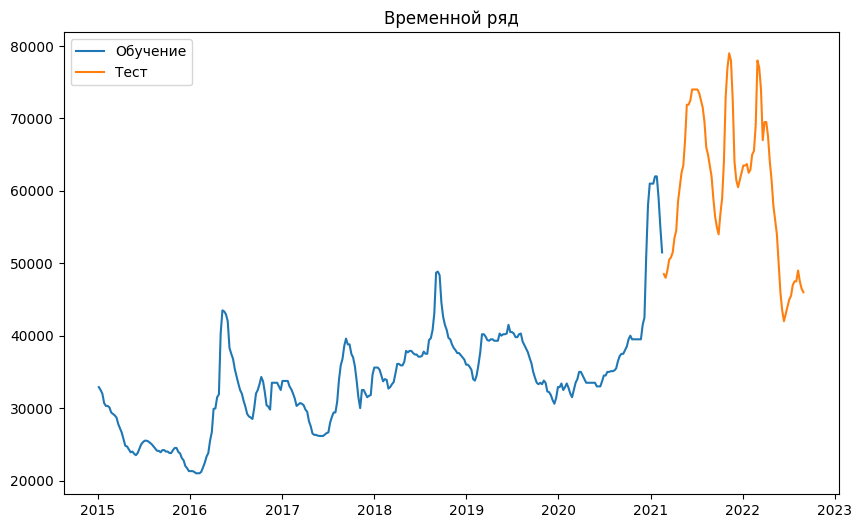

In [231]:
plt.figure(figsize=(10, 6))
plt.plot(train, label="Обучение")
plt.plot(test, label="Тест")
plt.legend()
plt.title("Временной ряд")
plt.show()

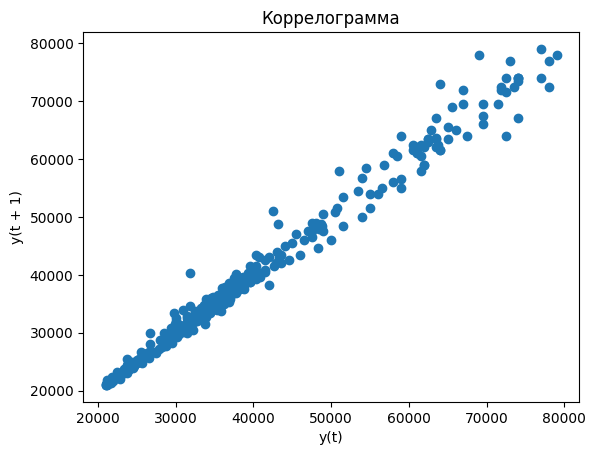

In [232]:
lag_plot(df['Цена на арматуру'])
plt.title('Коррелограмма')
plt.show()

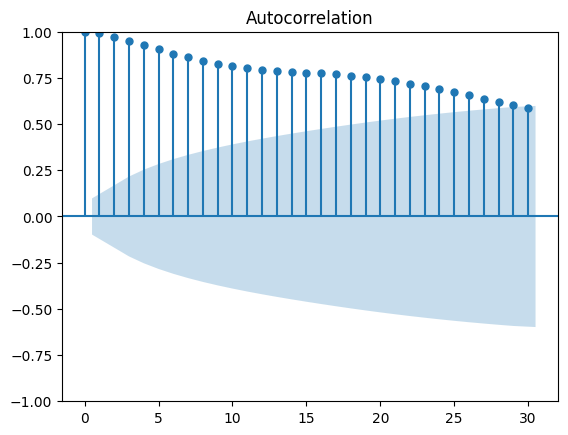

In [233]:
plot_acf(df, lags=30)
plt.show()

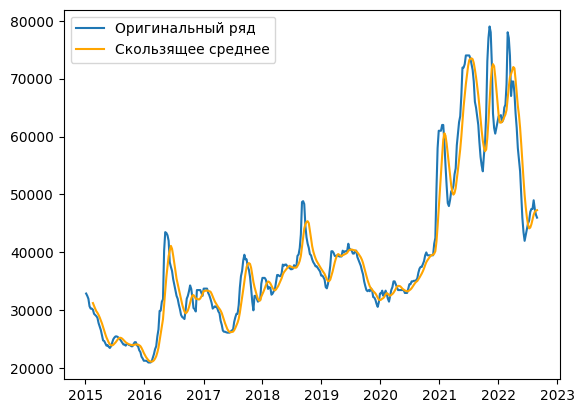

In [234]:
df['rolling_mean'] = df['Цена на арматуру'].rolling(window=7).mean()
plt.plot(df['Цена на арматуру'], label='Оригинальный ряд')
plt.plot(df['rolling_mean'], label='Скользящее среднее', color='orange')
plt.legend()
plt.show()

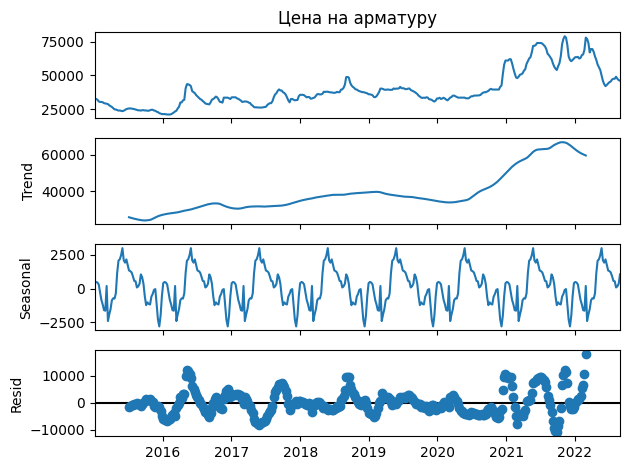

In [235]:
result = seasonal_decompose(df['Цена на арматуру'], model='additive')
result.plot()
plt.show()

In [236]:
train['diff'] = train['Цена на арматуру'].diff().dropna()

C:\Users\josha\AppData\Local\Temp\ipykernel_23744\902887630.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['diff'] = train['Цена на арматуру'].diff().dropna()


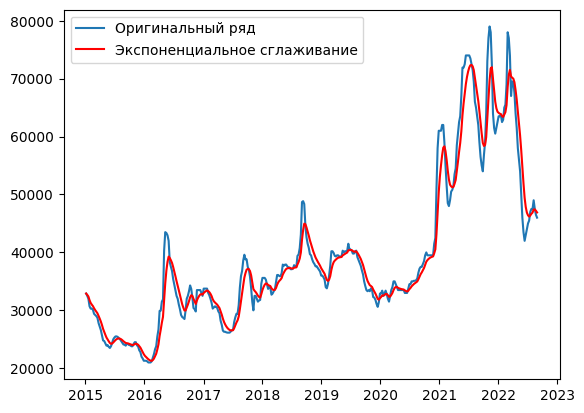

In [237]:
df['ewm'] = df['Цена на арматуру'].ewm(span=7).mean()
plt.plot(df['Цена на арматуру'], label='Оригинальный ряд')
plt.plot(df['ewm'], label='Экспоненциальное сглаживание', color='red')
plt.legend()
plt.show()


## Модели


In [238]:
arima_model = ARIMA(train['Цена на арматуру'], order=(5, 1, 2))
arima_fit = arima_model.fit()
arima_forecast = arima_fit.forecast(steps=len(test))

c:\Users\josha\OneDrive\Documents\GitHub\3_intensiv_3\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\josha\OneDrive\Documents\GitHub\3_intensiv_3\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\josha\OneDrive\Documents\GitHub\3_intensiv_3\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


In [239]:
hw_model = ExponentialSmoothing(train['Цена на арматуру'], trend='add', seasonal='add', seasonal_periods=12)
hw_fit = hw_model.fit()
hw_forecast = hw_fit.forecast(steps=len(test))


c:\Users\josha\OneDrive\Documents\GitHub\3_intensiv_3\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\josha\OneDrive\Documents\GitHub\3_intensiv_3\.venv\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [240]:
models = {'ARIMA': arima_forecast, 'Holt-Winters': hw_forecast}
for model_name, prediction in models.items():
    print(f"\n{model_name}:")
    print(f"MAE: {mean_absolute_error(test['Цена на арматуру'], prediction):.2f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(test['Цена на арматуру'], prediction)):.2f}")



ARIMA:
MAE: 13989.56
RMSE: 16730.82

Holt-Winters:
MAE: 147554.12
RMSE: 165985.50


In [241]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima_model = SARIMAX(
    train['Цена на арматуру'], 
    order=(5, 1, 2), 
    seasonal_order=(1, 1, 1, 12)
)
sarima_fit = sarima_model.fit()
sarima_forecast = sarima_fit.forecast(steps=len(test))

models['SARIMA'] = sarima_forecast

print("\nSARIMA:")
print(f"MAE: {mean_absolute_error(test['Цена на арматуру'], sarima_forecast):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(test['Цена на арматуру'], sarima_forecast)):.2f}")

c:\Users\josha\OneDrive\Documents\GitHub\3_intensiv_3\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\josha\OneDrive\Documents\GitHub\3_intensiv_3\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)



SARIMA:
MAE: 12686.36
RMSE: 14853.22


c:\Users\josha\OneDrive\Documents\GitHub\3_intensiv_3\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


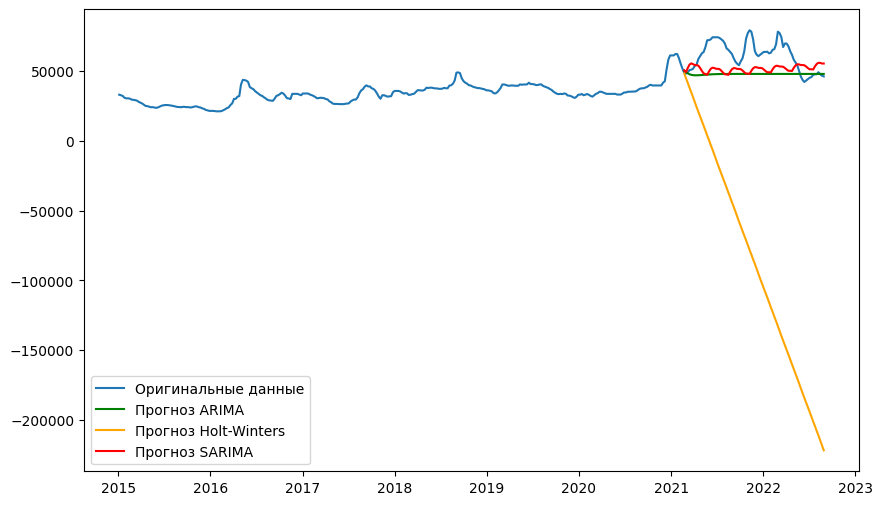

In [242]:
plt.figure(figsize=(10, 6))
plt.plot(df['Цена на арматуру'], label='Оригинальные данные')
plt.plot(test.index, arima_forecast, label='Прогноз ARIMA', color='green')
plt.plot(test.index, hw_forecast, label='Прогноз Holt-Winters', color='orange')
plt.plot(test.index, sarima_forecast, label='Прогноз SARIMA', color='red')
plt.legend()
plt.show()